In [1]:
import h5py
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from math import sqrt
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline

2024-04-25 19:17:02.489362: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 19:17:03.080161: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 19:17:05.281125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
NUM_CLASSES = 7
IMG_SHAPE = (48, 48, 3)
BATCH_SIZE = 8

TRAIN_EPOCH = 1
TRAIN_LR = 1e-3
TRAIN_ES_PATIENCE = 5
TRAIN_LR_PATIENCE = 3
TRAIN_MIN_LR = 1e-6
TRAIN_DROPOUT = 0.1

# FT_EPOCH = 500
# FT_LR = 1e-5
# FT_LR_DECAY_STEP = 80.0
# FT_LR_DECAY_RATE = 1
# FT_ES_PATIENCE = 20
# FT_DROPOUT = 0.2

ES_LR_MIN_DELTA = 0.003

# Data Loading

In [3]:
def load_data():
    x = pd.read_csv('datasets/fer2013.csv')

    train_set = x[(x.Usage == 'Training')]
    validation_set = x[(x.Usage == 'PublicTest')]
    test_set = x[(x.Usage == 'PrivateTest')]

    depth = 1
    height = int(sqrt(len(x.pixels[0].split())))
    width = height

    X_train = np.array(list(map(str.split, train_set.pixels)), np.float32)
    X_valid = np.array(list(map(str.split, validation_set.pixels)), np.float32)
    X_test = np.array(list(map(str.split, test_set.pixels)), np.float32)

    num_train = X_train.shape[0]
    num_validation = X_valid.shape[0]
    num_test = X_test.shape[0]

    X_train = X_train.reshape(num_train, width, height, depth)
    X_valid = X_valid.reshape(num_validation, width, height, depth)
    X_test = X_test.reshape(num_test, width, height, depth)

    def grayscale_to_rgb(images):
        # Repeat the single-channel grayscale image across three channels
        return np.repeat(images, 3, axis=-1)

    X_train = grayscale_to_rgb(X_train)
    X_valid = grayscale_to_rgb(X_valid)
    X_test = grayscale_to_rgb(X_test)

    y_train = train_set.emotion
    y_valid = validation_set.emotion
    y_test = test_set.emotion

    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = load_data()

In [4]:
# print (x.values.shape)
# x.head()

# print('Samples distribution across Usage:')
# print(x.Usage.value_counts())

# print('Samples per emotion:')
# print(x.emotion.value_counts())

# print('Number of pixels for a sample:')
# print(len(x.pixels[0].split(' ')))

# emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# print('Training: ',X_train.shape)
# print('Validation: ',X_valid.shape)
# print('Test: ',X_test.shape)

# print('Training: ',y_train.shape)
# print('Validation: ',y_valid.shape)
# print('Test: ',y_test.shape)

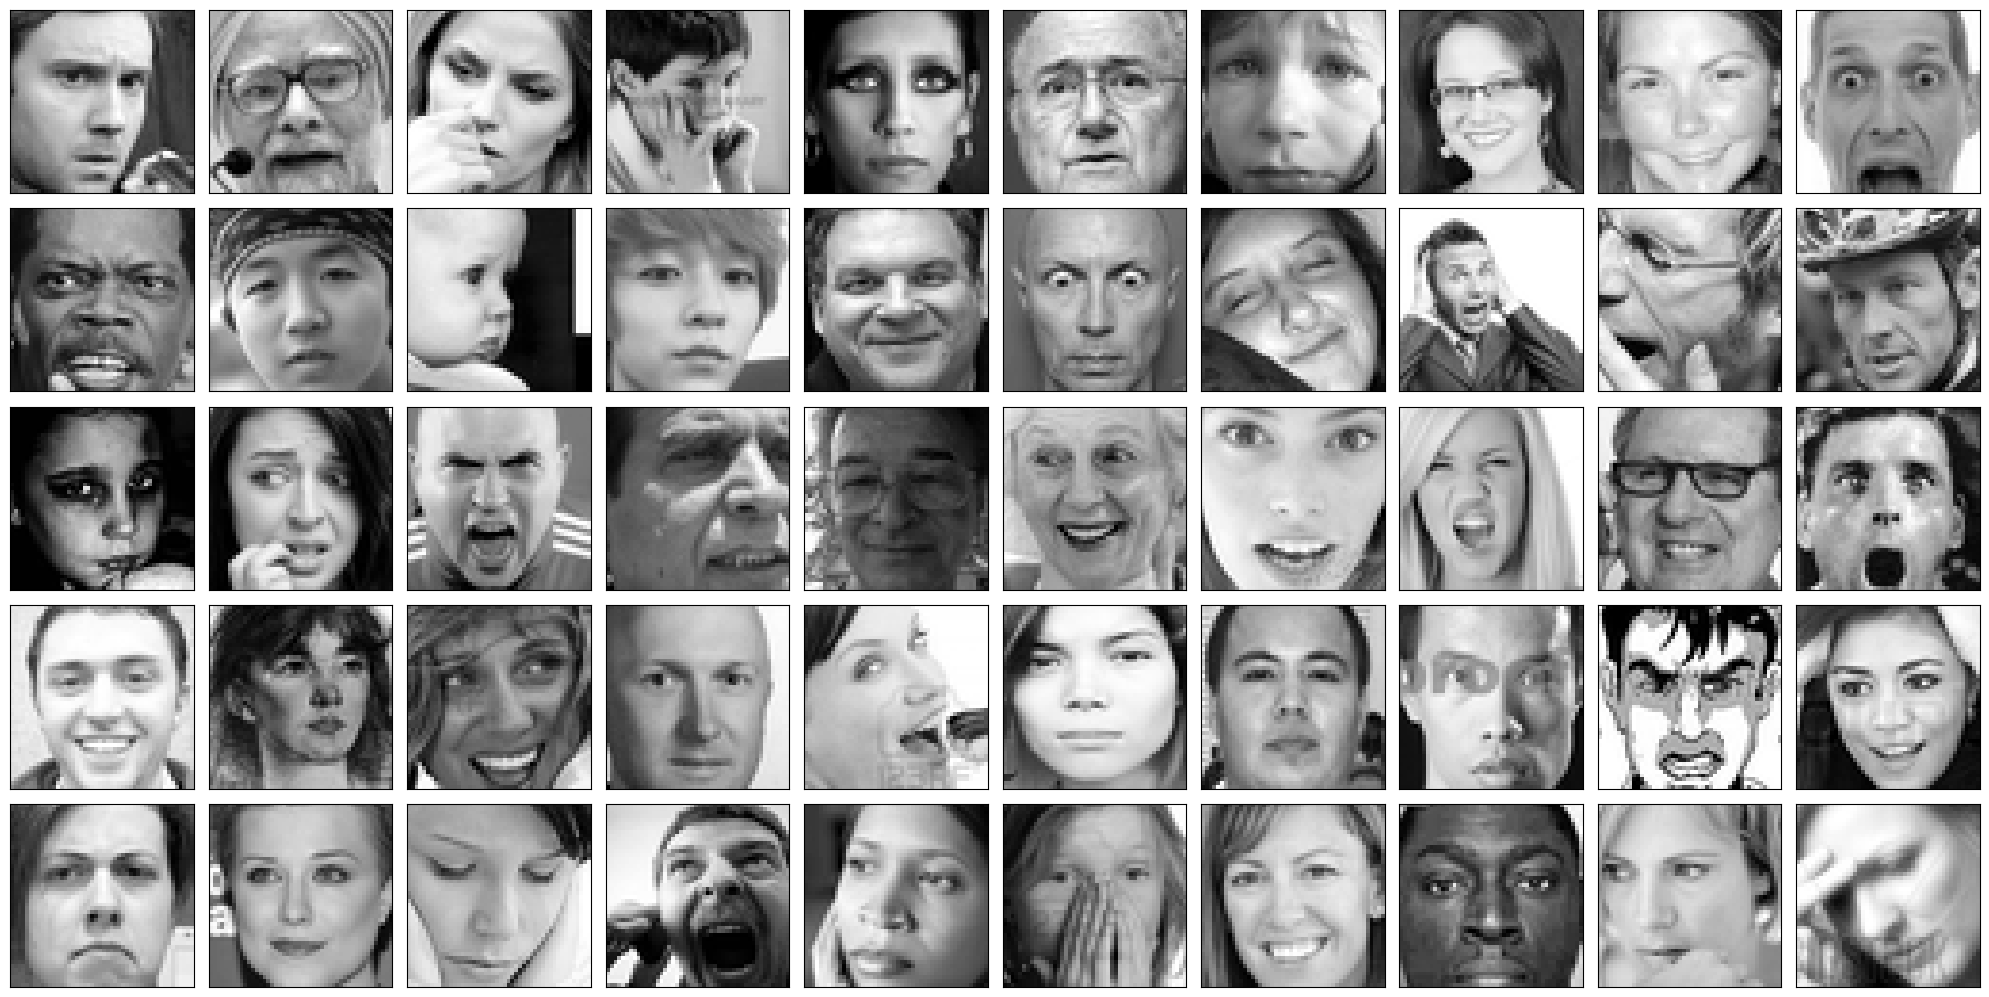

In [5]:
def overview(start, end, X):
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(10,10,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,50, X_train)

In [6]:
# Load your data here, PAtt-Lite was trained with h5py for shorter loading time
X_train, y_train = shuffle(X_train, y_train)

print("Shape of train_sample: {}".format(X_train.shape))
print("Shape of train_label: {}".format(y_train.shape))
print("Shape of valid_sample: {}".format(X_valid.shape))
print("Shape of valid_label: {}".format(y_valid.shape))
print("Shape of test_sample: {}".format(X_test.shape))
print("Shape of test_label: {}".format(y_test.shape))

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

Shape of train_sample: (28709, 48, 48, 3)
Shape of train_label: (28709,)
Shape of valid_sample: (3589, 48, 48, 3)
Shape of valid_label: (3589,)
Shape of test_sample: (3589, 48, 48, 3)
Shape of test_label: (3589,)


# Model Creation

In [9]:
def create_model():
    input_layer = tf.keras.Input(shape=IMG_SHAPE, name='universal_input')

    # Resize as MobileNet requires 244x244 images
    sample_resizing = tf.keras.layers.Resizing(224, 224, name="resize")

    # Flip and add contrast
    data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode='horizontal'), 
                                            tf.keras.layers.RandomContrast(factor=0.3)], name="augmentation")
    # Data ranges from [-1, 1]
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    backbone = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    base_model = tf.keras.Model(backbone.input, backbone.layers[-29].output, name='base_model')

    patch_extraction = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(256, kernel_size=4, strides=4, padding='same', activation='relu'), 
        tf.keras.layers.SeparableConv2D(256, kernel_size=2, strides=2, padding='valid', activation='relu'), 
        tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu')
    ], name='patch_extraction')

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='gap')

    pre_classification = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'), 
                                            tf.keras.layers.BatchNormalization()], name='pre_classification')

    prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name='classification_head')

    # Perform all operations
    inputs = input_layer
    x = sample_resizing(inputs)
    x = data_augmentation(x)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = patch_extraction(x)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(TRAIN_DROPOUT)(x)
    x = pre_classification(x)
    outputs = prediction_layer(x)

    model = tf.keras.Model(inputs, outputs, name='train-head')

    return model

model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=TRAIN_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "train-head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ universal_input (InputLayer)    │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize (Resizing)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_model (Functional)         │ (None, 7, 7, 960)      │       870,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_extraction (Sequential)   │ (None, 1, 1, 256)      │       393,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pre_classification (Sequential) │ (None, 32)             │         8,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head (Dense)     │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,272,711 (4.86 MB)

 Trainable params: 402,503 (1.54 MB)

 Non-trainable params: 870,208 (3.32 MB)

# Training the Model

In [11]:
# Training Procedure
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                           patience=TRAIN_ES_PATIENCE,  # how many epochs to wait before stopping
                                                           min_delta=ES_LR_MIN_DELTA,   # minimium amount of change to count as an improvement
                                                           restore_best_weights=True)

learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                              patience=TRAIN_LR_PATIENCE, 
                                                              verbose=0, 
                                                              min_delta=ES_LR_MIN_DELTA, 
                                                              min_lr=TRAIN_MIN_LR)

history = model.fit(X_train, y_train, epochs=TRAIN_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=0, 
                    class_weight=class_weights, callbacks=[early_stopping_callback, learning_rate_callback])

test_loss, test_acc = model.evaluate(X_test, y_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 593ms/step - accuracy: 0.5461 - loss: 1.2205


In [12]:
# model.save('model-mobilenet2.h5')
# model.save("model-mobilenet2.keras")

# Evaluation of the Model

In [20]:
def compute_model_size(model):
    # Initialize total size
    total_size = 0

    # Iterate through all model parameters
    for layer in model.layers:
        params = layer.get_weights()
        if params:
            for param in params:
                # Calculate size of each parameter
                param_size = np.prod(param.shape) * param.dtype.itemsize
                total_size += param_size

    # Convert total size to megabytes
    total_size_mb = total_size / (1024 * 1024)

    return total_size_mb

# Example usage:
model_size_mb = compute_model_size(model)
print("Model size: {:.2f} MB".format(model_size_mb))

Model size: 4.21 MB


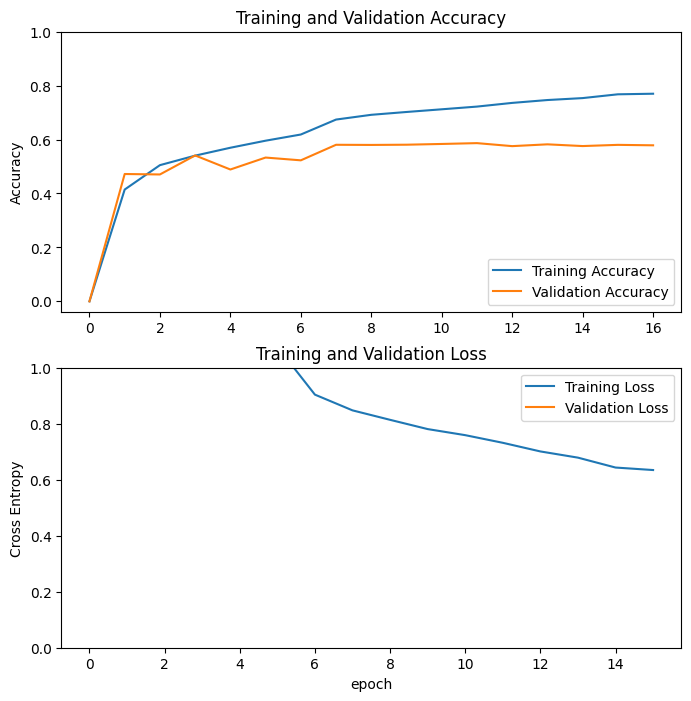

In [21]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
# Model Finetuning
# print("\nFinetuning ...")
# unfreeze = 59
# base_model.trainable = True
# fine_tune_from = len(base_model.layers) - unfreeze
# for layer in base_model.layers[:fine_tune_from]:
#     layer.trainable = False
# for layer in base_model.layers[fine_tune_from:]:
#     if isinstance(layer, tf.keras.layers.BatchNormalization):
#         layer.trainable = False

# inputs = input_layer
# x = sample_resizing(inputs)
# x = data_augmentation(x)
# x = preprocess_input(x)
# x = base_model(x, training=False)
# x = patch_extraction(x)
# x = tf.keras.layers.SpatialDropout2D(FT_DROPOUT)(x)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(FT_DROPOUT)(x)
# x = pre_classification(x)
# x = self_attention([x, x])
# x = tf.keras.layers.Dropout(FT_DROPOUT)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs, name='finetune-backbone')
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=FT_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# # Training Procedure
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=ES_LR_MIN_DELTA, patience=FT_ES_PATIENCE, restore_best_weights=True)

# scheduler = keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=FT_LR, decay_steps=FT_LR_DECAY_STEP, decay_rate=FT_LR_DECAY_RATE)
# scheduler_callback = tf.keras.callbacks.LearningRateScheduler(schedule=scheduler)


# # Define the learning rate schedule function
# # https://www.geeksforgeeks.org/learning-rate-decay/
# def lr_schedule(epoch, lr):
#     return lr / (1 + decay_rate * epoch / decay_steps)

# # Define the parameters for the learning rate schedule
# initial_learning_rate = FT_LR
# decay_steps = FT_LR_DECAY_STEP
# decay_rate = FT_LR_DECAY_RATE

# # Create the LearningRateScheduler callback
# # scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


# history_finetune = model.fit(X_train, y_train, epochs=FT_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=0, 
#                              initial_epoch=history.epoch[-TRAIN_ES_PATIENCE], callbacks=[early_stopping_callback, scheduler_callback, tensorboard_callback])

# test_loss, test_acc = model.evaluate(X_test, y_test)
# # model.save('model.h5')

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)

113/113 [==============================] - 55s 488ms/step - loss: 1.1594 - accuracy: 0.6046


In [25]:
model.summary()

Model: "finetune-backbone"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 universal_input (InputLayer)   [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 resize (Resizing)              (None, 224, 224, 3)  0           ['universal_input[0][0]']        
                                                                                                  
 augmentation (Sequential)      (None, 224, 224, 3)  0           ['resize[1][0]']                 
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 224, 224, 3)  0          ['augmentation[1][0]']           
                                                                                  

In [26]:
model.save("model2.keras")

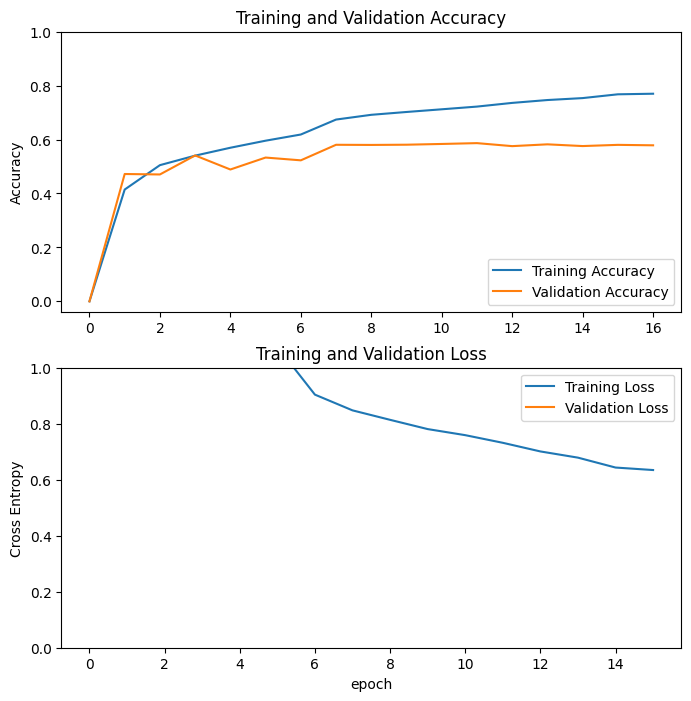

In [27]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
model_size_mb = compute_model_size(model)
print("Model size: {:.2f} MB".format(model_size_mb))

Model size: 4.21 MB
